In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

In [3]:
%cd /content/drive/MyDrive/intelImageClassification/Assignment3/

/content/drive/MyDrive/intelImageClassification/Assignment3


In [4]:
#Data Directories
train_dir = "/content/drive/MyDrive/intelImageClassification/seg_train/seg_train/"
valid_dir = "/content/drive/MyDrive/intelImageClassification/seg_test/seg_test/"
test_dir = "/content/drive/MyDrive/intelImageClassification/seg_pred/seg_pred/"

In [5]:
#Data Augmentation
#Image Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add data-augmentation parameters to ImageDataGenerator
#Training Data
augmentedDataGeneratorTrain = ImageDataGenerator(rescale = 1./255,
	    rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.01,
      zoom_range=[0.1, 1.5],
      horizontal_flip=True,
      fill_mode='nearest',
      zca_whitening=True,
      brightness_range=[0.1, 2]
)

augmentedTrainData=augmentedDataGeneratorTrain.flow_from_directory(
      train_dir,
      target_size=(150,150),
      batch_size=64,
      classes = ["buildings","forest","glacier","mountain","sea","street"],
      class_mode = 'categorical',
      seed=2209
    
)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 14034 images belonging to 6 classes.


In [6]:
#Validation Data
augmentedValidData=augmentedDataGeneratorTrain.flow_from_directory(
    valid_dir,
    target_size=(150,150),
    batch_size=64,
    classes = ["buildings","forest","glacier","mountain","sea","street"],
    class_mode = 'categorical',
    seed=2209 
)

Found 3000 images belonging to 6 classes.


In [7]:
#Test Data
augmentedDataGeneratorTest = ImageDataGenerator(rescale = 1./255.)
augmentedTestData = augmentedDataGeneratorTest.flow_from_directory(
    test_dir, 
    target_size=(150,150),
    batch_size=64,
    classes = ["buildings","forest","glacier","mountain","sea","street"],
    class_mode = 'categorical',
    seed=2209
) 

augmentedTestData2 = augmentedDataGeneratorTest.flow_from_directory(
    test_dir, 
    target_size=(150,150),
    batch_size=1,
#    class_mode=None,
    shuffle=False,
    classes = ["buildings","forest","glacier","mountain","sea","street"],
    class_mode = 'categorical',
    seed=2209
) 

Found 7301 images belonging to 6 classes.
Found 7301 images belonging to 6 classes.


In [8]:
#Splitting Validation, Training and Test data
X_train,y_train = augmentedTrainData.next()
X_valid,y_valid = augmentedValidData.next()
X_test,y_test = augmentedTestData.next()
X_test2,y_test2 = augmentedTestData2.next()

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [9]:
#One Hot encoding label images
lb = LabelBinarizer()
y_train_ohe = lb.fit_transform(y_train)
y_valid_ohe = lb.fit_transform(y_valid)
y_test_ohe = lb.fit_transform(y_test)
y_test2_ohe = lb.fit_transform(y_test2)

In [ ]:
#Loading VGG
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

# load VGG16 excluding classification layers
modelVGG = VGG16(include_top=False, input_shape=(150, 150, 3))

#Model summary before adding classification layers 
modelVGG.summary()

In [11]:
#Transfer Learning
#Adding New classification layers
flat1 = Flatten()(modelVGG.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer

In [ ]:
# defining new VGG model
modelVGG = Model(inputs=modelVGG.inputs, outputs=output)

#Model Summary after adding classification layers
modelVGG.summary()

In [8]:
#Loading ResNet50
from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
import numpy as np 
from keras.applications.resnet50 import ResNet50
import keras


modelResNet=ResNet50(include_top=False, weights= 'imagenet',  input_shape=(150,150,3), pooling='avg')
modelResNet.trainable = False

modelResNet.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
__________________________

In [9]:
#Transfer Learning ResNet
#Adding New classification layers
x = Dense(512, activation='relu')(modelResNet.output)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)

transfermodelResNet = Model(modelResNet.input, x)

#Model Summary after adding classification layers
transfermodelResNet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
#Compiling Model
#from keras.optimizers import SGD
#sgd = SGD(lr=0.00001, decay=1e-7, momentum=.9)
#modelVGG.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
modelVGG.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
#Compiling ResNet Model
from keras.optimizers import SGD
sgd = SGD(lr=0.0001, decay=1e-7, momentum=.9)
#transfermodelResNet.compile(optimizer =keras.optimizers.SGD(lr=0.0001),
transfermodelResNet.compile(optimizer =sgd, 
#              loss = 'sparse_categorical_crossentropy',
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
#Training Model
H=modelVGG.fit(X_train, y_train_ohe,
                    batch_size=64,
                    epochs=20,
                    validation_data=(X_valid, y_valid_ohe),
                    verbose=1)

In [ ]:
import tensorflow as tf
reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, mode='auto')
RN = transfermodelResNet.fit(
            augmentedTrainData,
            steps_per_epoch=int(augmentedTrainData.n//augmentedTrainData.batch_size),
            epochs=50,
            validation_data=augmentedValidData,
            validation_steps=int(augmentedValidData.n//augmentedValidData.batch_size),
            callbacks=[reduce],
            verbose=1)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
171/219 [======================>.......] - ETA: 10:07 - loss: 1.9091 - accuracy: 0.1735

In [15]:
# save the model's trained weights
modelVGG.save_weights('modifiedModelVGG_trained_wts.h5')
# saving model
modelVGG.save("modifiedModelVGG.h5")

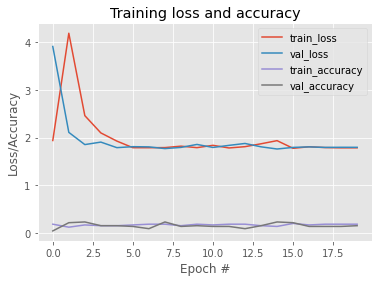

In [16]:
'''LEARNING CURVE'''

import matplotlib.pyplot as plt
N = np.arange(0, 20)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.plot(N, H.history['accuracy'], label='train_accuracy')
plt.plot(N, H.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [17]:
#Evaluate Test Data 1
score = modelVGG.evaluate(X_test, y_test, batch_size=32)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

#Evaluate Test Data 2
score2 = modelVGG.evaluate(X_test2, y_test2, batch_size=32)
print('Test Loss = ', score2[0])
print('Test Accuracy = ', score2[1])

2/2 [==============================] - 1s 37ms/step - loss: 1.7973 - accuracy: 0.1250
Test Loss =  1.7972865104675293
Test Accuracy =  0.125
1/1 [==============================] - 0s 324ms/step - loss: 1.7694 - accuracy: 0.0000e+00
Test Loss =  1.7693699598312378
Test Accuracy =  0.0
